In [1]:
# Ket noi google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 125.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.0 MB/s eta 0:00:00


In [4]:
import os
import shutil
import yaml

import numpy as np
import pandas as pd

from roboflow import Roboflow
from ultralytics import YOLO

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
ROOT = os.getcwd()
ROOT

'/content'

In [6]:
rf = Roboflow(api_key="8uJYXMJAcMiBvGznNnQn")
project = rf.workspace("nga-cuqly").project("supermarket-people-tuzqg")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Supermarket-people-1 in yolov11:: 100%|██████████| 2046/2046 [00:00<00:00, 3742.26it/s]


In [ ]:
import shutil

# --- Thiết lập biến đường dẫn ---
# Đổi tên thư mục này thành tên thư mục bạn đã tải lên Colab
SOURCE_FOLDER_NAME = "Supermarket-people-1"
SOURCE_PATH = f"/content/{SOURCE_FOLDER_NAME}"

# Tên thư mục đích trong Google Drive (sẽ được tạo nếu chưa tồn tại)
# Ví dụ: sẽ lưu vào /MyDrive/Colab_Saves/
DRIVE_DESTINATION_FOLDER = "Computer_Vision"
DESTINATION_PATH = f"/content/drive/MyDrive/{DRIVE_DESTINATION_FOLDER}/{SOURCE_FOLDER_NAME}"

# --- Bước 1: Gắn kết Google Drive ---
print("Bắt đầu gắn kết Google Drive...")

# --- Bước 2: Kiểm tra thư mục nguồn (SOURCE) ---
if not os.path.exists(SOURCE_PATH):
    print(f"\nLỖI: Không tìm thấy thư mục nguồn tại: {SOURCE_PATH}")
    print(f"Hãy đảm bảo bạn đã tải lên thư mục tên '{SOURCE_FOLDER_NAME}' vào Colab.")
else:
    print(f"\nThư mục nguồn đã sẵn sàng: {SOURCE_PATH}")

    # --- Bước 3: Thực hiện sao chép ---
    print(f"Bắt đầu sao chép thư mục '{SOURCE_FOLDER_NAME}' vào Drive...")
    try:
        # Tạo thư mục đích trong Drive nếu chưa có
        drive_save_dir = os.path.dirname(DESTINATION_PATH)
        os.makedirs(drive_save_dir, exist_ok=True)

        # Nếu thư mục đích đã tồn tại trong Drive, ta cần xóa nó trước
        # để tránh lỗi khi dùng shutil.copytree, hoặc đổi sang dùng lệnh shell !cp -r

        # Phương pháp 1: Sử dụng lệnh shell (thường nhanh hơn và dễ dàng hơn trong Colab)
        # Sử dụng !cp -r (copy recursive) để sao chép toàn bộ thư mục và nội dung
        !cp -r "$SOURCE_PATH" "$DESTINATION_PATH"
        print(f"\nQUAN TRỌNG: Đã sao chép thành công tới Drive tại: /MyDrive/{DRIVE_DESTINATION_FOLDER}/{SOURCE_FOLDER_NAME}")

        # Phương pháp 2 (Dùng Python shutil, cần xử lý xóa thư mục đích nếu đã tồn tại)
        # if os.path.exists(DESTINATION_PATH):
        #     shutil.rmtree(DESTINATION_PATH)
        # shutil.copytree(SOURCE_PATH, DESTINATION_PATH)

    except Exception as e:
        print(f"\nLỗi trong quá trình sao chép: {e}")
        print("Vui lòng kiểm tra lại đường dẫn và quyền truy cập Drive.")

print("\nQuá trình lưu trữ hoàn tất.")


Bắt đầu gắn kết Google Drive...

Thư mục nguồn đã sẵn sàng: /content/combined-trolley-1
Bắt đầu sao chép thư mục 'combined-trolley-1' vào Drive...

QUAN TRỌNG: Đã sao chép thành công tới Drive tại: /MyDrive/Computer_Vision/combined-trolley-1

Quá trình lưu trữ hoàn tất.


In [ ]:
os.listdir(DESTINATION_PATH)

['README.dataset.txt',
 'README.roboflow.txt',
 'data.yaml',
 'test',
 'train',
 'valid']

In [ ]:
import yaml

# Kiem tra file yaml
with open (f"{DESTINATION_PATH}/data.yaml", 'r') as file:
    # num_classes = str(yaml.safe_load(stream)['nc'])
    config = yaml.safe_load(file)
    print(config)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 1, 'names': ['trolley'], 'roboflow': {'workspace': 'dfa-sx7ur', 'project': 'combined-trolley-gvv78', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/dfa-sx7ur/combined-trolley-gvv78/dataset/1'}}


In [ ]:
print(f"So luong du lieu tap train: {len(os.listdir(f'{DESTINATION_PATH}/train/images'))}")
print(f"So luong du lieu tap val: {len(os.listdir(f'{DESTINATION_PATH}/valid/images'))}")

So luong du lieu tap train: 385
So luong du lieu tap val: 75


In [ ]:
from ultralytics import YOLO
import pandas as pd

# Khởi tạo mô hình YOLOv8
# Sử dụng 'yolov8n.pt' (nano) để bắt đầu nhanh, hoặc 'yolov8s.pt' (small) cho hiệu suất tốt hơn
model = YOLO('yolov8n.pt')

print("\nBắt đầu quá trình huấn luyện YOLOv8...")

# Lệnh huấn luyện
# --data: Đường dẫn đến file data.yaml (chứa thông tin về đường dẫn tập train/val và số lượng class)
# --epochs: Số lượng epoch huấn luyện
# --imgsz: Kích thước ảnh đầu vào (ví dụ 640x640)
# --batch: Kích thước batch size (tùy thuộc vào GPU, 16 là mức an toàn)
# --project: Thư mục gốc để lưu kết quả
# --name: Tên thư mục con cụ thể cho lần chạy này

RESULTS_PATH = f"/content/drive/MyDrive/{DRIVE_DESTINATION_FOLDER}/{SOURCE_FOLDER_NAME}_trainer"
drive_save_dir_trainer = os.path.dirname(RESULTS_PATH)
os.makedirs(drive_save_dir_trainer, exist_ok=True)
results = model.train(
    data=f"{DESTINATION_PATH}/data.yaml",  # File cấu hình dữ liệu từ Roboflow
    epochs=100,            # Số lượng epoch (thử nghiệm với 50-100)
    imgsz=640,            # Kích thước hình ảnh
    batch=16,             # Kích thước batch
    project=RESULTS_PATH, # Lưu kết quả vào Google Drive
    patience=50,
    name='demo_run'  # Tên lần chạy
    # plots = True
)


Bắt đầu quá trình huấn luyện YOLOv8...
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Computer_Vision/combined-trolley-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=demo_run, nbs=64, nms=False, opset=None, optimize=False, o

invalid escape sequence '\s'
invalid escape sequence '\s'
invalid escape sequence '\s'


Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.2 ms, read: 41.4±14.0 MB/s, size: 84.8 KB)
train: Scanning /content/drive/MyDrive/Computer_Vision/combined-trolley-1/train/labels.cache... 385 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 385/385 479.7Kit/s 0.0s
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 4.0±2.2 ms, read: 6.7±2.0 MB/s, size: 72.9 KB)
val: Scanning /content/drive/MyDrive/Computer_Vision/combined-trolley-1/valid/labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 75/75 26.9Kit/s 0.0s
Plotting labels to /content/

KeyError: "None of [Index(['epoch', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)'], dtype='object')] are in the [columns]"

In [ ]:
# df = pd.DataFrame()
run_dir = results.save_dir
print(f"Run Dir {run_dir}")
results_csv_path = os.path.join(run_dir, 'results.csv')

print(f"\n3. Huấn luyện hoàn tất. Đường dẫn kết quả: {run_dir}")

# --- Trích xuất dữ liệu mAP từ file CSV ---
if os.path.exists(results_csv_path):
    print("4. Đang đọc và trích xuất chỉ số mAP từ results.csv...")

    # Đọc file CSV, bỏ qua 6 dòng đầu tiên (chứa comments/header không cần thiết)
    df = pd.read_csv(results_csv_path)

# Thong tin columns cua df
df.columns

Run Dir /content/drive/MyDrive/Computer_Vision/combined-trolley-1_trainer/demo_run

3. Huấn luyện hoàn tất. Đường dẫn kết quả: /content/drive/MyDrive/Computer_Vision/combined-trolley-1_trainer/demo_run
4. Đang đọc và trích xuất chỉ số mAP từ results.csv...


Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')

In [ ]:


def create_custom_subplot_layout():
    """
    Tạo một figure Matplotlib với bố cục 2 hàng:
    - Hàng 1: 1 biểu đồ chính (chiếm toàn bộ chiều rộng).
    - Hàng 2: 3 biểu đồ phụ.
    """

    # 1. Khởi tạo Figure
    fig = plt.figure(figsize=(12, 8))
    fig.suptitle('Detection Metrics', fontsize=16)

    # 2. Định nghĩa GridSpec (Lưới 2 Hàng x 3 Cột)
    # Chúng ta cần 3 cột để chứa 3 biểu đồ phụ ở hàng dưới.
    gs = gridspec.GridSpec(2, 3, figure=fig)

    # 3. Biểu đồ Chính (Hàng 1)
    # Chiếm hàng 0 (đầu tiên), và tất cả các cột (từ 0 đến 2)
    ax_main = fig.add_subplot(gs[0, :])

    # Tạo dữ liệu giả định
    X = np.arange(1, 101)
    Y1 = df['metrics/mAP50(B)']
    Y2 = df['metrics/mAP50-95(B)']

    # Vẽ biểu đồ chính
    ax_main.plot(X, Y1, color='darkblue', linewidth=2)
    ax_main.plot(X, Y2, color='darkgreen', linewidth=2)
    # ax_main.bar(X, df['time'], width= 2)
    ax_main.set_title('mAP50 | mAP50-95')
    ax_main.grid(axis='y', linestyle='--', alpha=0.6)
    ax_main.set_xlabel('Epochs')
    ax_main.set_ylabel('Accuracy')

    # 4. Ba Biểu đồ Phụ (Hàng 2)

    # Biểu đồ phụ 1 (Hàng 1, Cột 0)
    ax_sub1 = fig.add_subplot(gs[1, 0])
    ax_sub1.plot(X, df['train/box_loss'], color='skyblue')
    ax_sub1.grid(axis='y', linestyle='--', alpha=0.6)
    ax_sub1.set_title('Train Box Loss')

    # Biểu đồ phụ 2 (Hàng 1, Cột 1)
    ax_sub2 = fig.add_subplot(gs[1, 1])
    ax_sub2.plot(X, df['train/cls_loss'], color='red')
    ax_sub2.grid(axis='y', linestyle='--', alpha=0.6)
    ax_sub2.set_title('Train Class Loss')

    # Biểu đồ phụ 3 (Hàng 1, Cột 2)
    ax_sub3 = fig.add_subplot(gs[1, 2])
    ax_sub3.plot(X, df['train/dfl_loss'], color='green')
    ax_sub3.set_title('Train dfl Loss')
    ax_sub3.grid(axis='y', linestyle='--', alpha=0.6)

    # 5. Điều chỉnh khoảng cách giữa các biểu đồ để tránh chồng lấn
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh cho tiêu đề chính

    # 6. Hiển thị Figure
    plt.show()

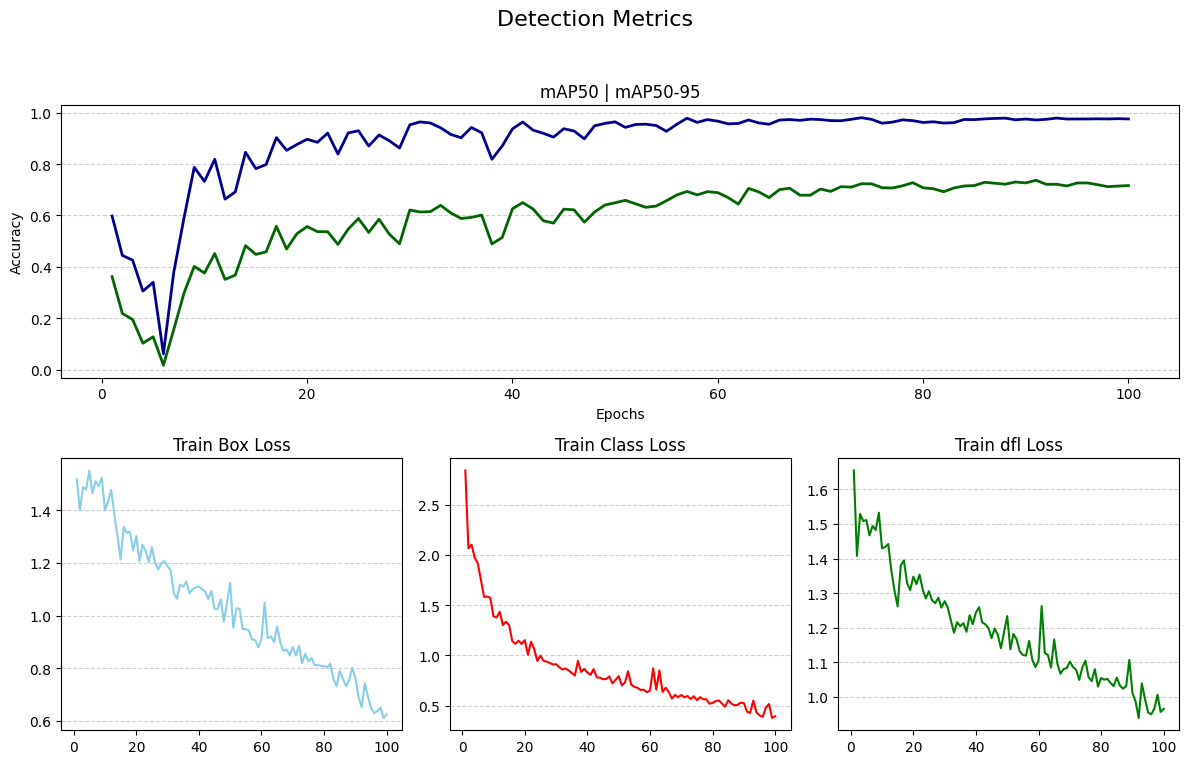

In [ ]:
    create_custom_subplot_layout()